In [24]:
import cv2
import s3fs
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.morphology import skeletonize
from skimage import filters
from skimage import measure
from glob import glob
from PIL import Image
import numpy as np

In [8]:
!rm -rf ../predicts
!mkdir ../predicts

In [13]:
!aws s3 cp --recursive --quiet s3://ml-for-seismic-data-interpretation/predictions/ ../predicts/

In [14]:
predicts = sorted(glob('../predicts/*'))
predicts[:5]

['../predicts/kerry_626.png',
 '../predicts/kerry_627.png',
 '../predicts/kerry_628.png',
 '../predicts/kerry_629.png',
 '../predicts/kerry_756.png']

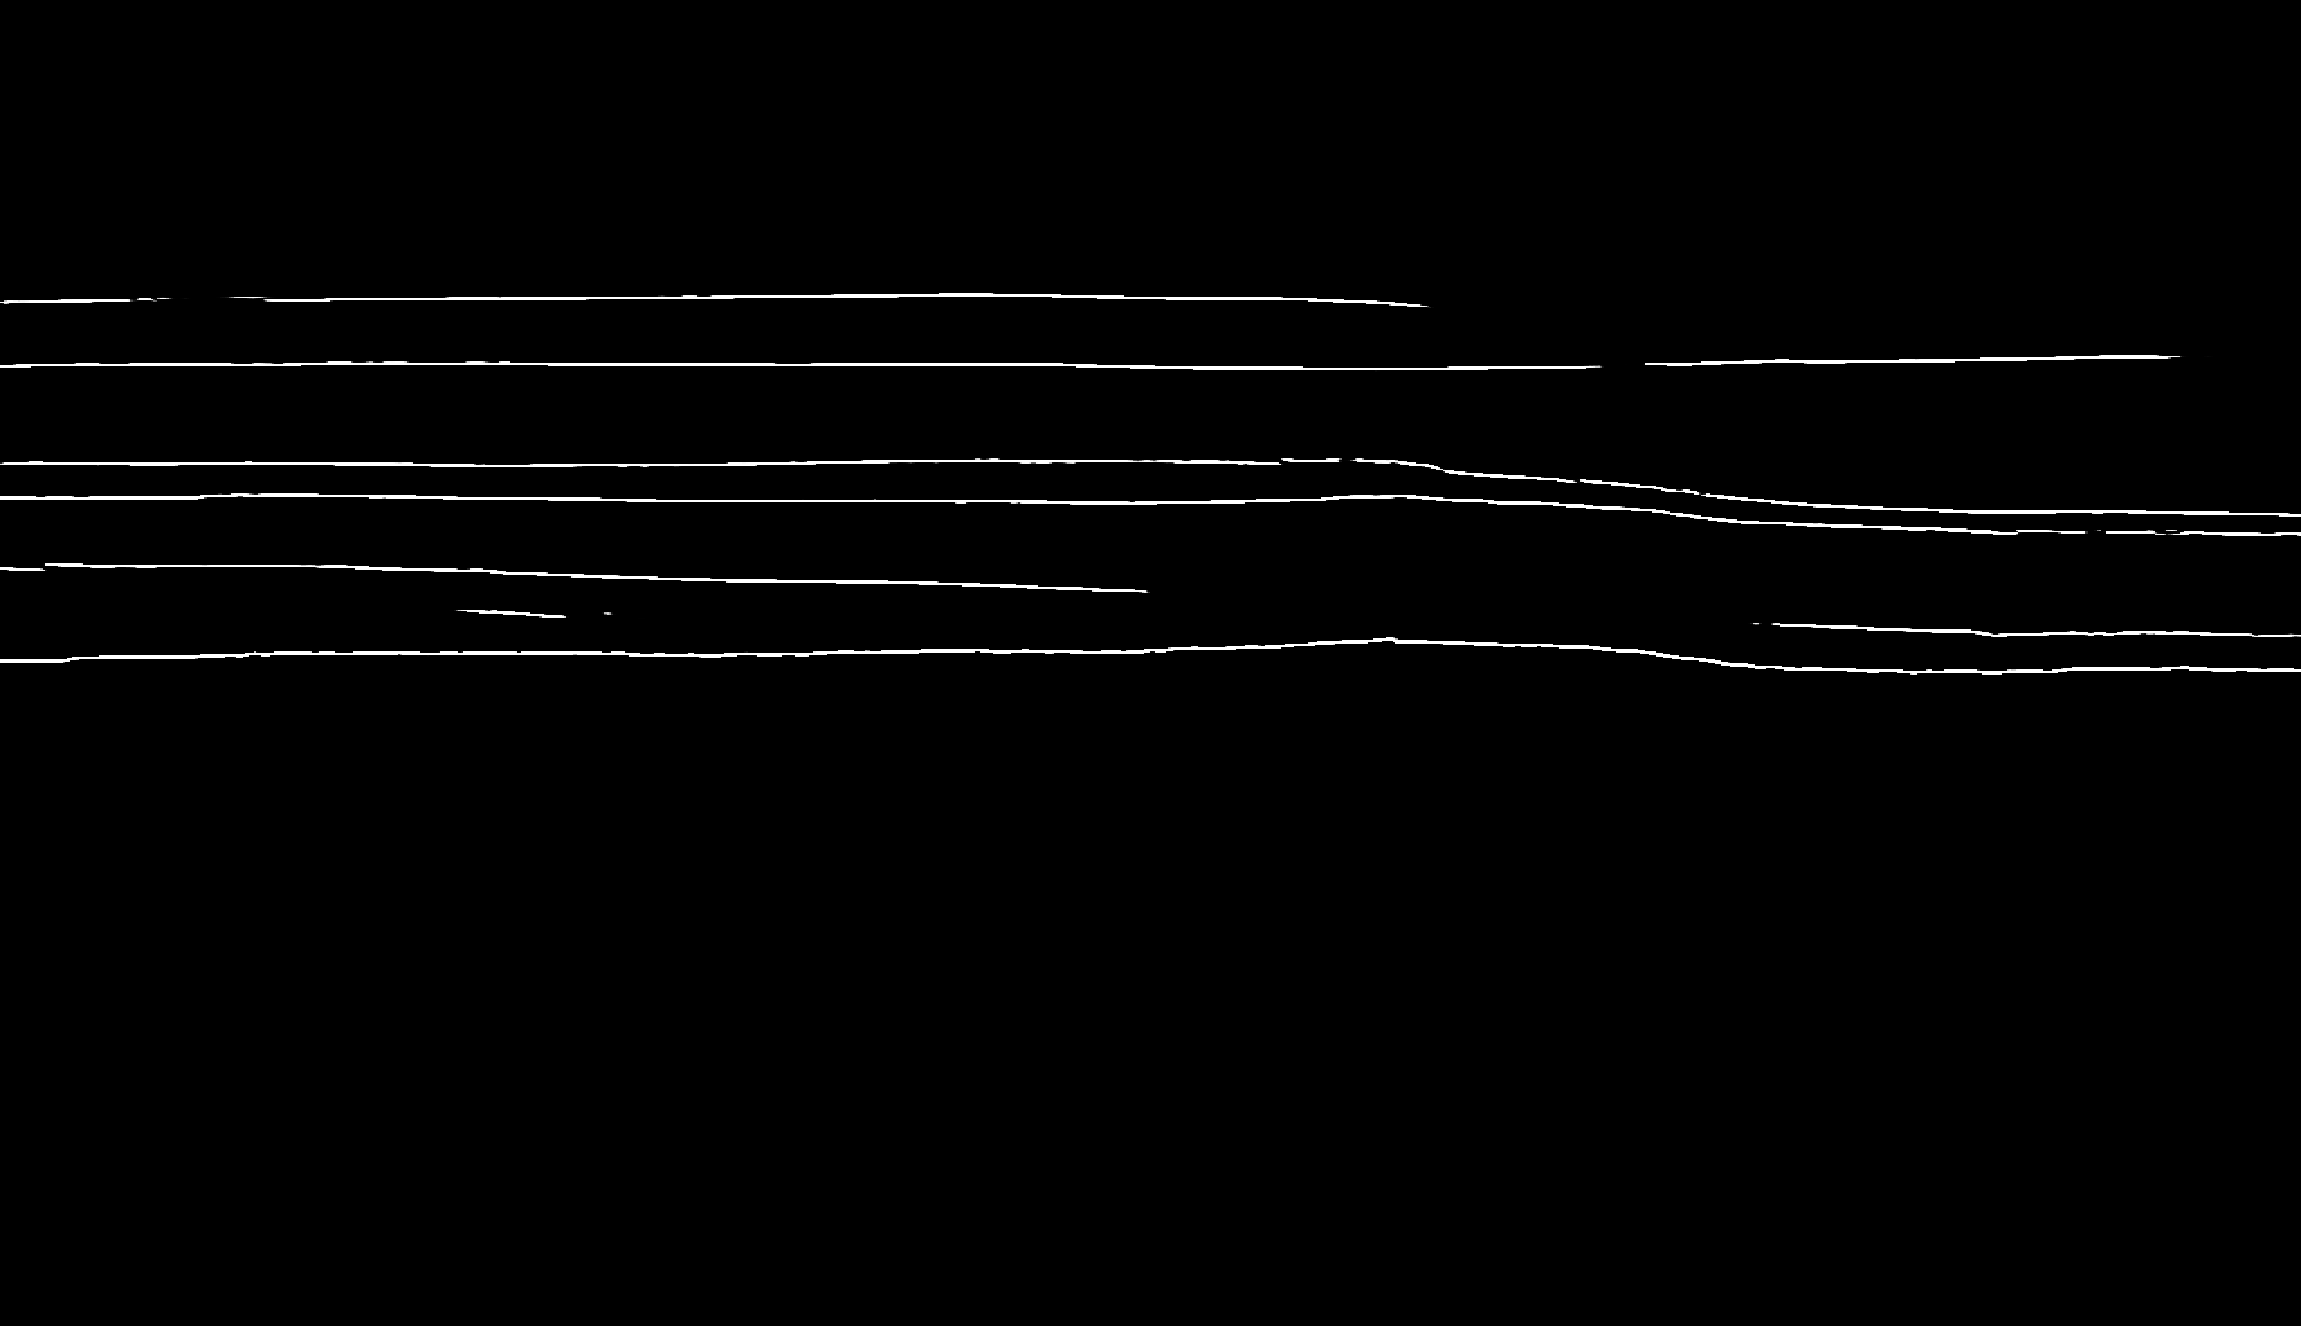

In [18]:
Image.open(predicts[-1])

## Predicts postprocessing

### Step1: Skeletonization

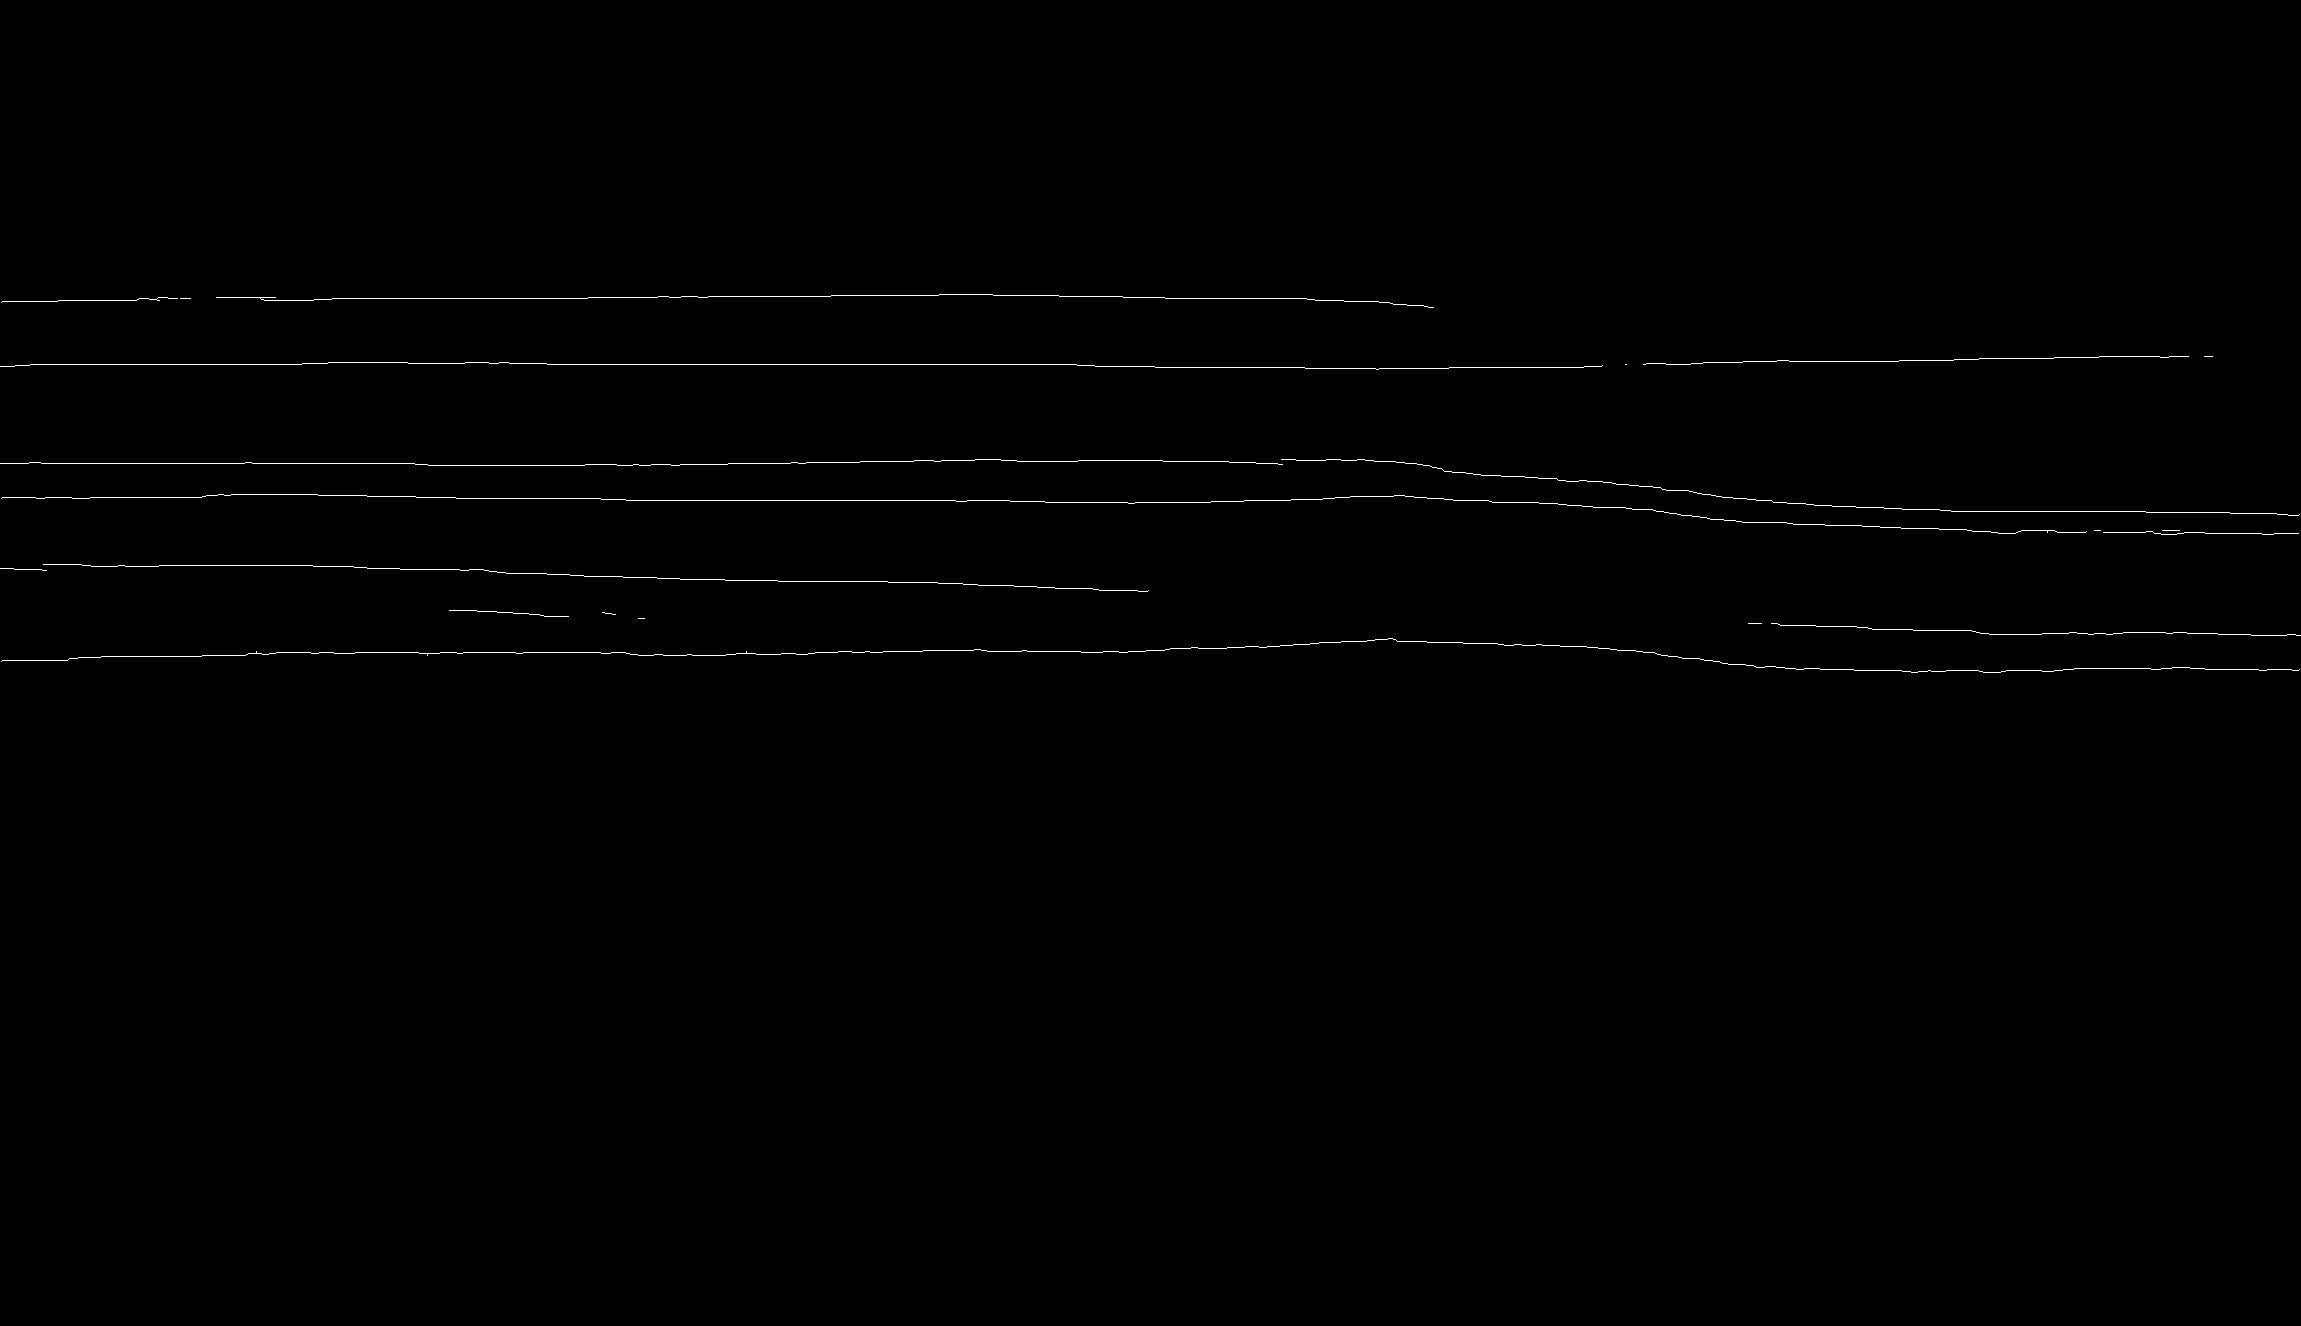

In [25]:
predict = cv2.imread(predicts[-1], cv2.IMREAD_GRAYSCALE)
predict[predict!=0]=1
predict = skeletonize(predict).astype(np.uint8)
Image.fromarray(predict*255)

### Step2: connected components labeling

In [26]:
from scipy import ndimage

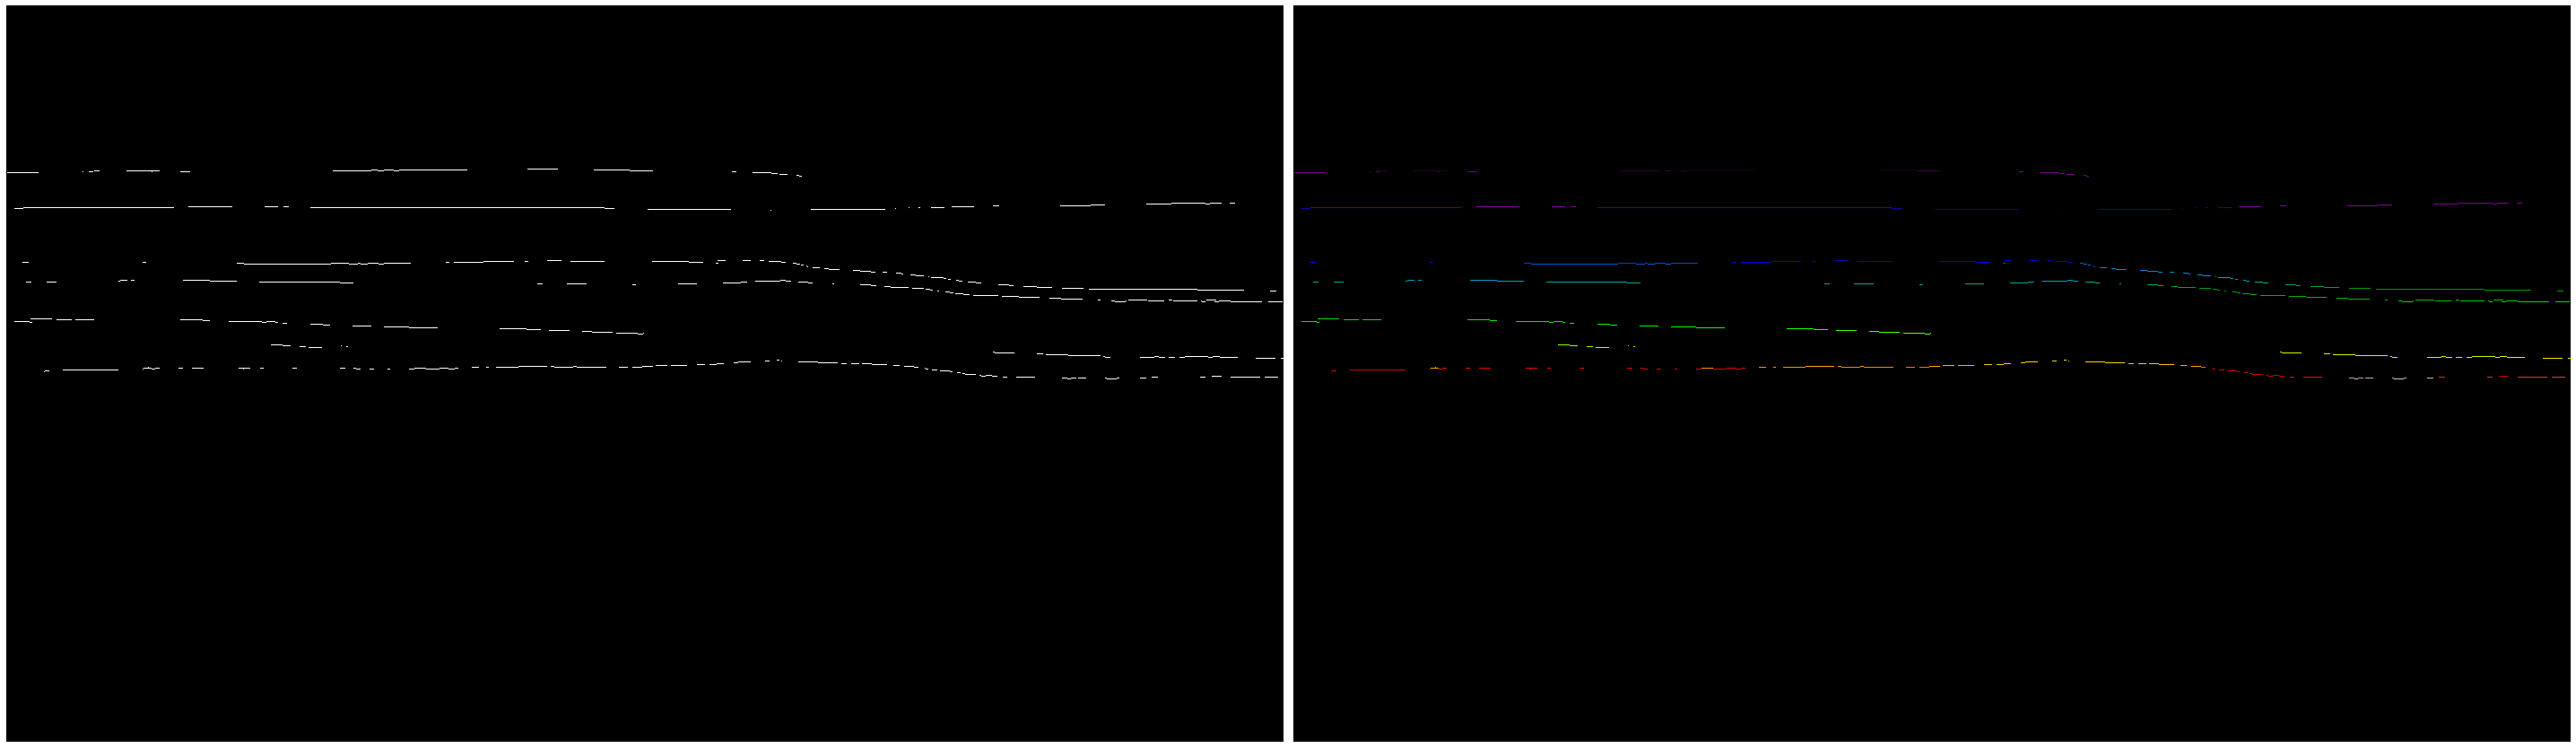

In [37]:
conn_comp = ndimage.label(predict)
comp_mask, comp_num = conn_comp[0], conn_comp[1]

plt.figure(figsize=(40, 20))
plt.subplot(121)
plt.imshow(predict*255, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(comp_mask, cmap='nipy_spectral')
plt.axis('off')


plt.tight_layout()
plt.show()

### Note: Components merging
The next step is merging the components into horizons, but as this requires analysis of contextual information between inlines, cross-lines, and depth-slices, this is out of the context of this notebook.

In [43]:
def postproc_predict(predict_path):
    predict = cv2.imread(predict_path, cv2.IMREAD_GRAYSCALE)
    predict[predict!=0]=1
    predict = skeletonize(predict).astype(np.uint8)
    conn_comp = ndimage.label(predict)
    return conn_comp


## Reconstructing the OpendTect export file

### Reading a sample exporty file to get the structure

In [44]:
fs = s3fs.S3FileSystem()
annotation_file = f's3://ml-for-seismic-data-interpretation/Annotations/Parihaka_h_ix_bulk.dat'
raw_dat_content = [l.decode('utf-8') for l in fs.open(annotation_file).readlines()]
raw_dat_content[:10]

['# "Inline"\t"Crossline"\t"Z"\n',
 '# - - - - - - - - - -\n',
 '"h_antique_01"\t2601\t4200\t2306.90836906\n',
 '"h_antique_01"\t2601\t4201\t2306.35046959\n',
 '"h_antique_01"\t2601\t4202\t2305.92775345\n',
 '"h_antique_01"\t2602\t4200\t2306.85067177\n',
 '"h_antique_01"\t2602\t4201\t2306.48946762\n',
 '"h_antique_01"\t2602\t4202\t2305.98044395\n',
 '"h_antique_01"\t2602\t4203\t2305.44114113\n',
 '"h_antique_01"\t2602\t4204\t2304.49652672\n']

### Extracting the header, which indicates each new horizon (component)

In [45]:
header = raw_dat_content[:2]
header

['# "Inline"\t"Crossline"\t"Z"\n', '# - - - - - - - - - -\n']

In [46]:
def dump_predicts(predicts, header, start_xline, z_step):
    new_dat = []
    for pred in predicts:
        idx = pred.split('/')[-1].split('.')[0].split('_')[1]
        pred_mask, comp_num = postproc_predict(pred)

        for val in range(1, comp_num+1):
            new_dat.extend(header)
            for xl, z in zip(np.where(pred_mask==val)[0], np.where(pred_mask==val)[1]):
                line = f'"h_{idx}_{val}"\t{idx}\t{start_xline+xl}\t{z*z_step}\n'
                new_dat.append(line)
    return new_dat

### Filtering only parihaka predictions

In [47]:
parihaka_predicts = list(filter(lambda x: 'parihaka' in x, predicts))

### Dumping masks into the export format

In [48]:
export_data = dump_predicts(parihaka_predicts, header, 4200, 3)

In [49]:
export_data[:10]

['# "Inline"\t"Crossline"\t"Z"\n',
 '# - - - - - - - - - -\n',
 '"h_1759_1"\t1759\t4299\t2145\n',
 '"h_1759_1"\t1759\t4299\t2148\n',
 '"h_1759_1"\t1759\t4299\t2151\n',
 '"h_1759_1"\t1759\t4299\t2154\n',
 '"h_1759_1"\t1759\t4299\t2157\n',
 '"h_1759_1"\t1759\t4299\t2160\n',
 '"h_1759_1"\t1759\t4299\t2163\n',
 '"h_1759_1"\t1759\t4299\t2166\n']

In [50]:
!mkdir ../exports

### Writing export data to a file and uploading to s3

In [52]:
with open("../exports/parihaka_testset.dat", 'w') as f:
    f.writelines(export_data)

In [53]:
!aws s3 cp ../exports/parihaka_testset.dat s3://ml-for-seismic-data-interpretation/exports-to-opendtect/

upload: ../exports/parihaka_testset.dat to s3://ml-for-seismic-data-interpretation/exports-to-opendtect/parihaka_testset.dat


In [54]:
!rm -rf ../predicts
!rm -rf ../exports